In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 50000
N_CRITICS = 5
CLIP_VALUE = 0.01

In [3]:
def load_data():
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis = 3)
    return x_train

In [4]:
x_train = load_data()
x_train.shape

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28, 1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batc

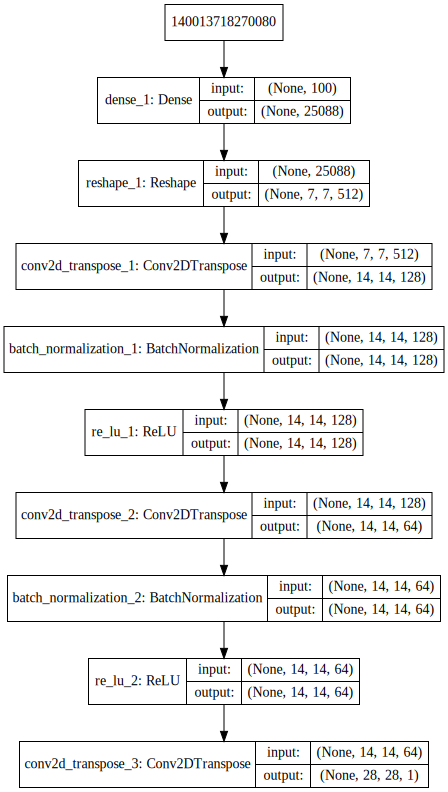

In [5]:
generator = Sequential([
    Dense(7 * 7 * 512, input_shape = (LATENT_DIMENSION, ), kernel_initializer = RandomNormal(stddev = 0.2)),
    Reshape((7, 7, 512)),
    Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    ReLU(0.2),
    Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    ReLU(0.2),
    Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = 'same', activation = 'tanh')
])

generator.summary()

SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
__________

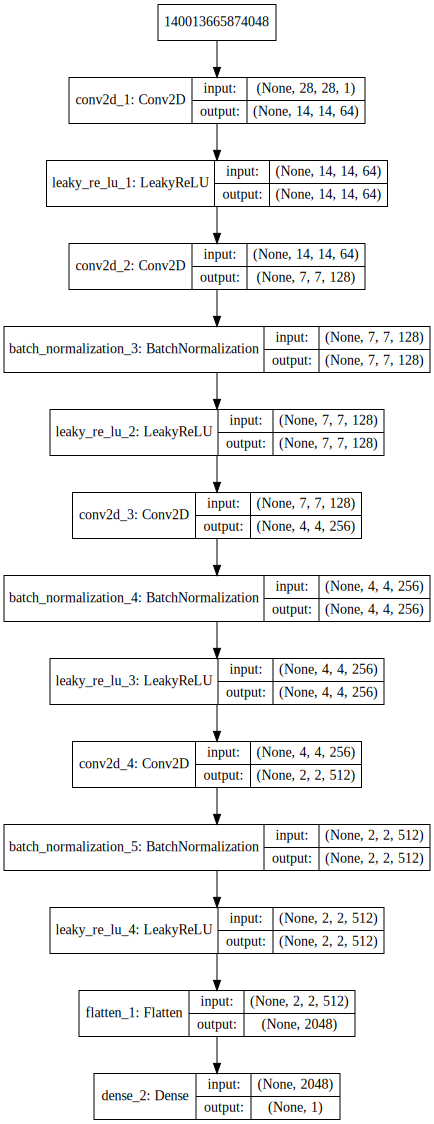

In [6]:
critic = Sequential([
    Conv2D(64, kernel_size = 3, strides = 2, padding = 'same', input_shape = IMAGE_SHAPE),
    LeakyReLU(0.2),
    Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(0.2),
    Conv2D(256, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(0.2),
    Conv2D(512, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(0.2),
    Flatten(),
    Dense(1)
])

critic.summary()

SVG(model_to_dot(critic, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [7]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [8]:
optimizer = RMSprop(lr = 0.00005)

In [9]:
critic.compile(optimizer = optimizer, loss = wasserstein_loss, metrics = ['accuracy'])

In [10]:
critic.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         3198977   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1555457   
Total params: 4,754,434
Trainable params: 3,198,593
Non-trainable params: 1,555,841
_________________________________________________________________


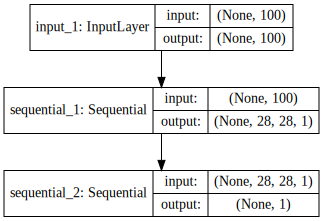

In [11]:
z = Input(shape = (LATENT_DIMENSION,))
image = generator(z)
validity = critic(image)
gan = Model(z, validity)
gan.compile(optimizer = optimizer, loss = wasserstein_loss, metrics = ['accuracy'])

gan.summary()

SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
valid = -np.ones(shape = (BATCH_SIZE, 1))
fake = np.ones(shape = (BATCH_SIZE, 1))
generator_loss_history, critic_loss_history = [], []

In [13]:
def plot_images(nrows, ncols, figsize, generator):
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    noise = np.random.normal(0, 1, (nrows * ncols, LATENT_DIMENSION))
    generated_images = generator.predict(noise).reshape(nrows * ncols, IMAGE_WIDTH, IMAGE_HEIGHT)
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap = 'gray')
    plt.show()

  2%|▏         | 999/50000 [04:21<3:26:11,  3.96it/s]

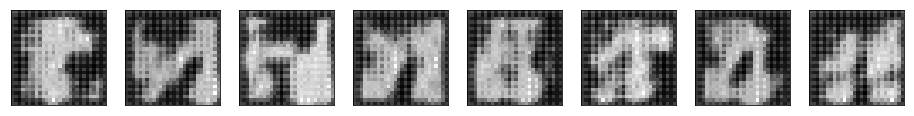

  4%|▍         | 1999/50000 [08:30<3:21:37,  3.97it/s]

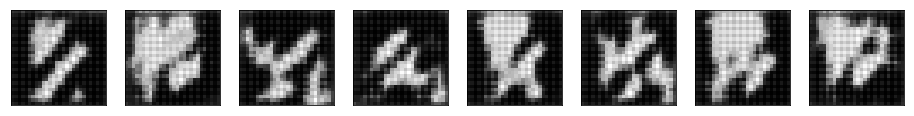

  6%|▌         | 2999/50000 [12:42<3:20:17,  3.91it/s]

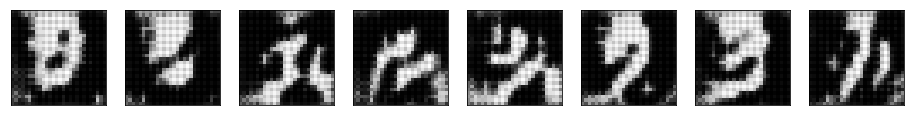

  8%|▊         | 3999/50000 [16:59<3:11:43,  4.00it/s]

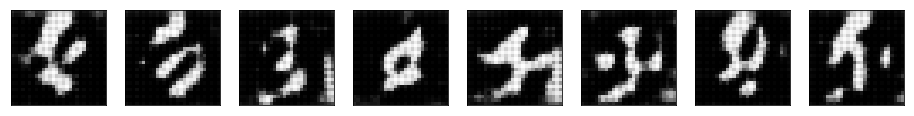

 10%|▉         | 4999/50000 [21:09<3:04:10,  4.07it/s]

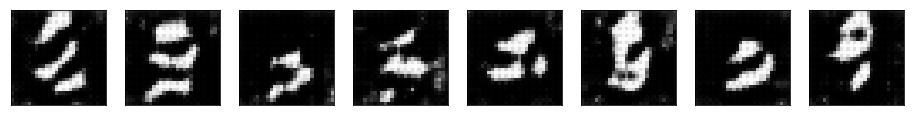

 12%|█▏        | 5927/50000 [25:06<3:07:43,  3.91it/s]

In [14]:
for epoch in tqdm(range(1, EPOCHS + 1)):

    for _ in range(N_CRITICS):

        # Select a random batch
        index = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
        batch_images = x_train[index]

        # Adversarial Noise
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIMENSION))

        # Generate fake Images
        fake_images = generator.predict(noise)

        # Train the Critic
        critic.trainable = True
        critic_loss_real = critic.train_on_batch(batch_images, valid)
        critic_loss_fake = critic.train_on_batch(fake_images, fake)
        critic_loss = 0.5 * (critic_loss_real[0] + critic_loss_fake[0])

        # Clip critic weights
        for layer in critic.layers:
            weights = layer.get_weights()
            weights = [np.clip(w, - CLIP_VALUE, CLIP_VALUE) for w in weights]
            layer.set_weights(weights)

    critic.trainable = False

    # Train the Generator
    generator_loss = gan.train_on_batch(noise, valid)

    generator_loss_history.append(generator_loss)
    critic_loss_history.append(critic_loss)

    if epoch % 1000 == 0:
        plot_images(1, 8, (16, 4), generator)

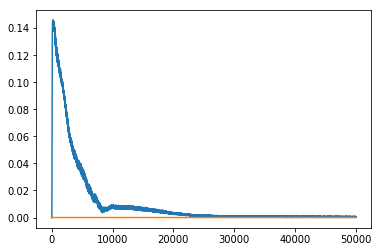

In [15]:
plt.plot(generator_loss_history)
plt.show()

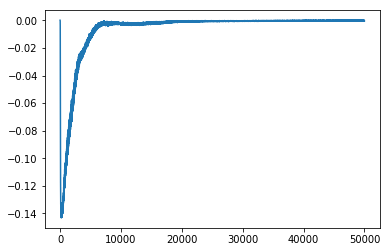

In [16]:
plt.plot(critic_loss_history)
plt.show()

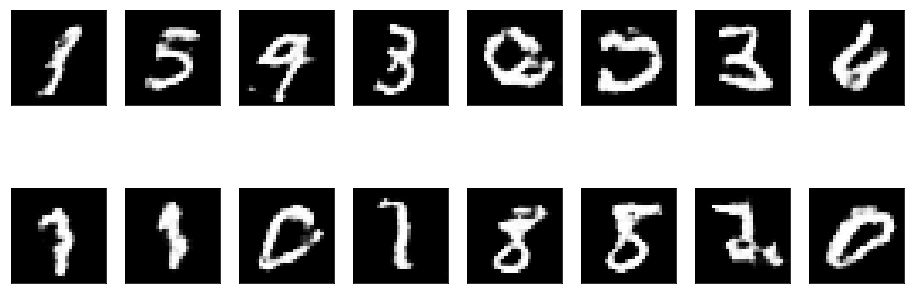

In [17]:
plot_images(2, 8, (16, 6), generator)

In [18]:
generator.save('generator.h5')